In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os

from fastai.conv_learner import *
from fastai.dataset import *

import cv2

#cv2.CV_LOAD_IMAGE_GRAYSCALE

from pathlib import Path
import json

## Path to Data

In [4]:
PATH = Path('/data/airbus')
list(PATH.iterdir())

[PosixPath('/data/airbus/sample_submission.csv'),
 PosixPath('/data/airbus/tmp'),
 PosixPath('/data/airbus/train_ship_segmentations.csv'),
 PosixPath('/data/airbus/train'),
 PosixPath('/data/airbus/models'),
 PosixPath('/data/airbus/test'),
 PosixPath('/data/airbus/train-128'),
 PosixPath('/data/airbus/train_masks'),
 PosixPath('/data/airbus/train_masks-128')]

In [5]:
import pandas as pd

segments = pd.read_csv(PATH/'train_ship_segmentations.csv')
segments.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


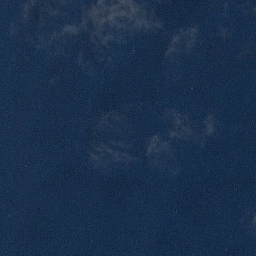

In [6]:
image = Image.open(PATH/'train/00003e153.jpg').resize((256, 256))
image

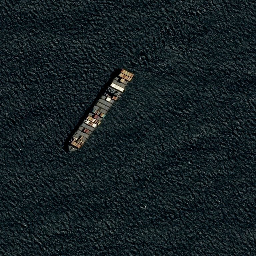

In [14]:
image = Image.open(PATH/f"train/{segments.loc[20, 'ImageId']}").resize((256, 256))
image

# Run Length Decoding

In [15]:
encoded = np.array(segments.loc[20, 'EncodedPixels'].split(), dtype = int)

In [16]:
encoded[:10]

array([146366,      1, 147132,      4, 147899,      5, 148666,      7, 149432,     10])

In [17]:
def rle_decode_mine(encoded, height = 768, width = 768):
    m_f = np.zeros(height * width, dtype = np.uint8)
    pixels = encoded[::2] - 1
    num = encoded[1::2]

    # Iterate through the pixels
    for start, n_p in zip(pixels, num):
        m_f[start: start + n_p] = 255

    return m_f.reshape((height, width)).T

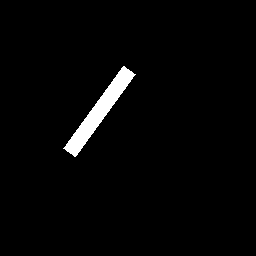

In [18]:
mask = rle_decode_mine(encoded)
Image.fromarray(mask).resize((256, 256))

In [19]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

## All Masks for a single image

In [46]:
def all_masks(image_id, height = 768, width = 768):
    subset = segments[segments['ImageId'] == f'{image_id}']
    all_masks = np.zeros((height, width), dtype=np.uint8)
    
    for encoding in subset['EncodedPixels'].dropna():
        all_masks += rle_decode_mine(np.array(encoding.split(), int))
        
    return all_masks

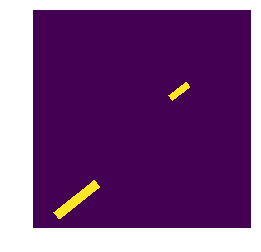

In [48]:
all_masks_exp = all_masks('0005d01c8.jpg'); show_img(all_masks_exp);

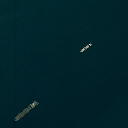

In [49]:
Image.open(f'{PATH}/train/0005d01c8.jpg').resize((128, 128))

In [50]:
import random
def show_image_with_mask(image_id = None, return_ax = False):
    if not image_id:
        image_id = random.sample(list(segments['ImageId'].unique()), 1)[0]
    ax = show_img(open_image(f'{PATH}/train/{image_id}'))
    all_masks_exp = all_masks(image_id)
    ax = show_img(all_masks_exp, ax = ax, alpha = 0.5)

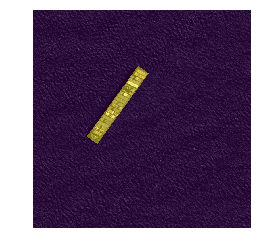

In [51]:
image_id = str(segments.loc[20, 'ImageId'])
show_image_with_mask(image_id)

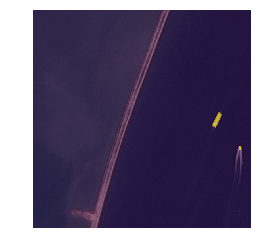

In [63]:
show_image_with_mask()

## Open Image with CV2

In [64]:
np.array(cv2.imread('test.png')).shape

(768, 768, 3)

In [65]:
np.array(cv2.imread('test.png', cv2.IMREAD_GRAYSCALE)).shape

(768, 768)

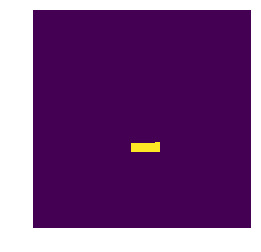

In [66]:
show_img(cv2.imread('test.png', cv2.IMREAD_GRAYSCALE));

In [67]:
np.array(Image.open('test.png')).shape

(768, 768)

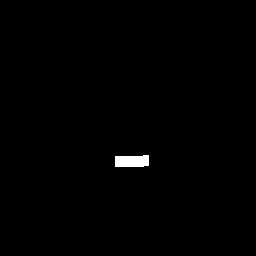

In [68]:
Image.open('test.png').resize((256, 256))

# Save all rle as masks


In [69]:
from timeit import default_timer as timer

In [70]:
segments['ImageId'].nunique()

104070

In [71]:
MASK_PATH = PATH/'train_masks'
# os.mkdir(MASK_PATH)

In [75]:
start = timer()

# Iterate through ids and save each mask
for img_id in segments['ImageId'].unique():
    Image.fromarray(all_masks(img_id)).save(f'{MASK_PATH}/{img_id[:-4]}.png')
    
end = timer()

print(f'{end - start} seconds elapsed.')

2615.200833891 seconds elapsed.


In [76]:
list(MASK_PATH.iterdir())[:15]

[PosixPath('/data/airbus/train_masks/2f7006078.png'),
 PosixPath('/data/airbus/train_masks/e099868ab.png'),
 PosixPath('/data/airbus/train_masks/bffdaa7aa.png'),
 PosixPath('/data/airbus/train_masks/7490438f1.png'),
 PosixPath('/data/airbus/train_masks/2c9c48b4b.png'),
 PosixPath('/data/airbus/train_masks/d0109dfaf.png'),
 PosixPath('/data/airbus/train_masks/f41a4b6bf.png'),
 PosixPath('/data/airbus/train_masks/4a2f199f1.png'),
 PosixPath('/data/airbus/train_masks/8e0846a9e.png'),
 PosixPath('/data/airbus/train_masks/4a92d7048.png'),
 PosixPath('/data/airbus/train_masks/4a86316a8.png'),
 PosixPath('/data/airbus/train_masks/f1a048e88.png'),
 PosixPath('/data/airbus/train_masks/d723f66f2.png'),
 PosixPath('/data/airbus/train_masks/f155d78ca.png'),
 PosixPath('/data/airbus/train_masks/41265c303.png')]

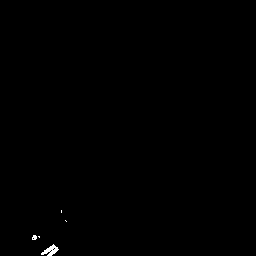

In [77]:
Image.open('/data/airbus/train_masks/00021ddc3.png').resize((256, 256))

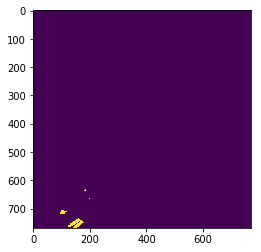

In [78]:
plt.imshow(cv2.imread('/data/airbus/train_masks/00021ddc3.png', cv2.IMREAD_GRAYSCALE))

In [79]:
cv2.imread(f'/data/airbus/train_masks/{first_16[0][:-4]}.png')[..., 0]

NameError: name 'first_16' is not defined

In [ ]:
show_img(open_image(f'/data/airbus/train_masks/{first_16[0][:-4]}.png')[..., 0])

In [ ]:
%%timeit -n 1 -r 10 
i = first_16[0]; cv2.imread(f'/data/airbus/train/{i[:-4]}.jpg');

In [ ]:
%%timeit -n 1 -r 10 
i = first_16[0]; open_image(f'/data/airbus/train/{i[:-4]}.jpg');

In [ ]:
first_16 = list(segments['ImageId'].unique()[:16])

In [ ]:
ims = [open_image(f'/data/airbus/train/{i[:-4]}.jpg') for i in first_16]
im_masks = [open_image(f'/data/airbus/train_masks/{i[:-4]}.png')[..., 0] for i in first_16]

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [ ]:
last_16 = list(segments['ImageId'].unique()[-16:])
ims = [open_image(f'/data/airbus/train/{i[:-4]}.jpg') for i in last_16]
im_masks = [open_image(f'/data/airbus/train_masks/{i[:-4]}.png')[..., 0] for i in last_16]
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

# Save all masks as 768 x 768

In [ ]:
start = timer()
def save_masks(img_id):
    Image.fromarray(all_masks(img_id)).save(f'{MASK_PATH}/{img_id[:-4]}.png')
    
with ThreadPoolExecutor(8) as e: e.map(save_masks, segments['ImageId'].unique())
end = timer()

print(f'{end - start} seconds elapsed.')

In [ ]:
%%timeit -n 5 -r 10
mask = rle_decode_mine(np.array(encoded, np.uint8))

In [ ]:
mask_mine = rle_decode_mine(np.array(encoded, int))

In [ ]:
def rle_decode(mask_rle, shape= (768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 255
    return img.reshape(shape).T

In [ ]:
%%timeit -n 5 -r 10
mask = rle_decode(segments.loc[2, 'EncodedPixels']);

In [ ]:
mask = rle_decode(segments.loc[2, 'EncodedPixels']);

In [ ]:
mask.sum()

In [ ]:
mask_mine.sum()

In [ ]:
fn = list((MASK_PATH).iterdir())[0]
fn.parent.parent/'train_masks-128'

In [ ]:
fn.name

In [ ]:
fn = list((PATH/'train').iterdir())[0]
fn.parent/fn.name

In [ ]:
PATH/'train-128'/fn.name

## Resize All Images to 128 x 128

In [ ]:
start = timer()
def resize_img(fn):
    Image.open(fn).resize((128, 128)).save(PATH/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)
end = timer()
print(f'{end - start} seconds elapsed.')

In [ ]:
len(list((PATH/f'train-128').iterdir()))

In [ ]:
segments['ImageId'].nunique()

In [ ]:
list((PATH/'train-128').iterdir())[:10]

## Resize all masks to 128 x 128

In [ ]:
start = timer()
def resize_mask(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((MASK_PATH).iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)
end = timer()
print(f'{end - start} seconds elapsed.')

In [ ]:
len(list((PATH/f'train_masks-128').iterdir()))

In [ ]:
list((PATH/'train_masks-128').iterdir())[:10]

In [ ]:
ims = []
im_masks = []

for image_id in segments['ImageId'].unique()[-16:]:
    ims.append(Image.open(PATH/f'train-128/{image_id[:-4]}.jpg'))
    im_masks.append(cv2.imread(f'{PATH}/train_masks-128/{image_id[:-4]}.png'))

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][..., 0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [ ]:
ims = []
im_masks = []

for image_id in random.sample(list(segments['ImageId'].unique()), 16):
    ims.append(Image.open(PATH/f'train-128/{image_id[:-4]}.jpg'))
    im_masks.append(cv2.imread(f'{PATH}/train_masks-128/{image_id[:-4]}.png'))
    
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][..., 0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

# Implementation from Fastai Carvana

https://github.com/fastai/fastai/blob/master/courses/dl2/carvana.ipynb

In [ ]:
TRAIN_DN = Path('/data/airbus/train-128')
MASK_DN = Path('/data/airbus/train_masks-128/')

sz = 128
bs = 32

In [ ]:
x_names = np.array([Path(TRAIN_DN)/o for o in segments['ImageId'].unique()])
y_names = np.array([Path(MASK_DN)/f'{o[:-4]}.png' for o in segments['ImageId'].unique()])

In [ ]:
len(x_names)

In [ ]:
len(y_names)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
val_idxs = list(range(104070))
trn_x, val_x, trn_y, val_y = train_test_split(x_names, y_names)
len(val_x), len(trn_x)

In [ ]:
class  MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [ ]:
aug_tfms = [RandomFlip(tfm_y = TfmType.CLASS),
            RandomRotate(4, tfm_y = TfmType.CLASS)]

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, 
                       tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)

In [ ]:
PATH

In [ ]:
datasets = ImageData.get_ds(MatchedFilesDataset,
                            (trn_x, trn_y), (val_x, val_y),
                            tfms, path = PATH)
md = ImageData(PATH, datasets, bs, num_workers = 8, classes = None)

In [ ]:
denorm = md.trn_ds.denorm
x, y = next(iter(md.aug_dl))
x = denorm(x)

In [ ]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

# Model

In [ ]:
class Empty(nn.Module):
    def forward(self, x): return x
    
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head = Empty())
learn = ConvLearner(md, models)
learn.summary()

In [ ]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride = 2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))
    

In [ ]:
flatten_channel = Lambda(lambda x: x[:, 0])

In [ ]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512, 256),
    StdUpsample(256, 256),
    StdUpsample(256, 256),
    StdUpsample(256, 256),
    nn.ConvTranspose2d(256, 1, 2, stride = 2),
    flatten_channel
)

In [ ]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head = simple_up)
learn = ConvLearner(md, models)

In [ ]:
learn.opt_fn = optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn_metrics = [accuracy_thresh(0.5)]

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
learn.save('tmp')
learn.load('tmp')

# Fit with all layers

In [ ]:
lr = 0.1
learn.fit(lr, 1, cycle_len = 5, use_clr = (20, 5))

In [ ]:
py, ay = learn.predict_with_targs()
ay.shape

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax =  show_img(denorm(x)[9])
show_img(ay[9], ax=ax, alpha=0.5);

In [ ]:
ay[8]

In [ ]:
show_img(ay[8])

In [ ]:
segments[segments['ImageId'] == '6384c3e78.jpg']

In [ ]:
show_img(open_image(PATH/'train/6384c3e78.jpg'))

In [ ]:
Image.fromarray(cv2.imread(f'{PATH}/train/6384c3e78.jpg')).resize((128, 128)).save(f'{PATH}/train-128/6384c3e78.jpg')

In [ ]:
Image.open('/data/airbus/train-128/6384c3e78.jpg')